
Epoch 1: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 1/50
50/50 [==============================] - 2s 10ms/step - loss: 11.1145 - accuracy: 0.6288 - auc: 0.6809 - lr: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 2/50
50/50 [==============================] - 1s 12ms/step - loss: 9.8903 - accuracy: 0.7397 - auc: 0.8154 - lr: 1.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 3/50
50/50 [==============================] - 0s 10ms/step - loss: 8.7831 - accuracy: 0.7722 - auc: 0.8507 - lr: 1.0000e-04

Epoch 4: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 4/50
50/50 [==============================] - 1s 11ms/step - loss: 7.7810 - accuracy: 0.8006 - auc: 0.8781 - lr: 1.0000e-04

Epoch 5: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 5/50
50/50 [==============================] - 1s 11ms/step - loss: 6.8902

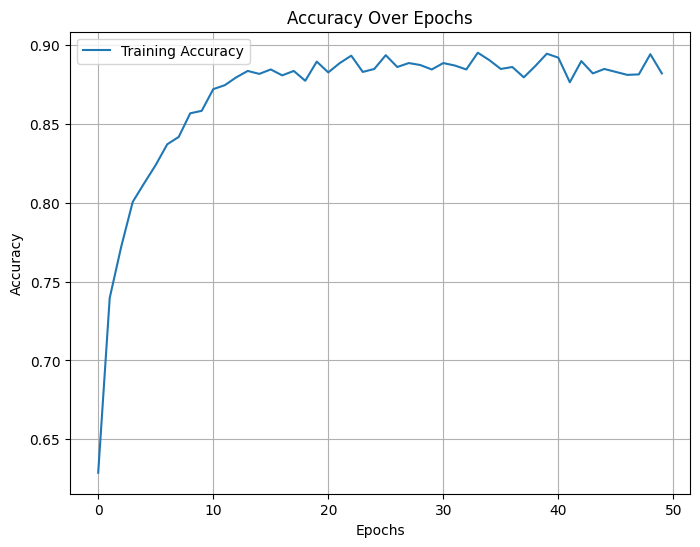

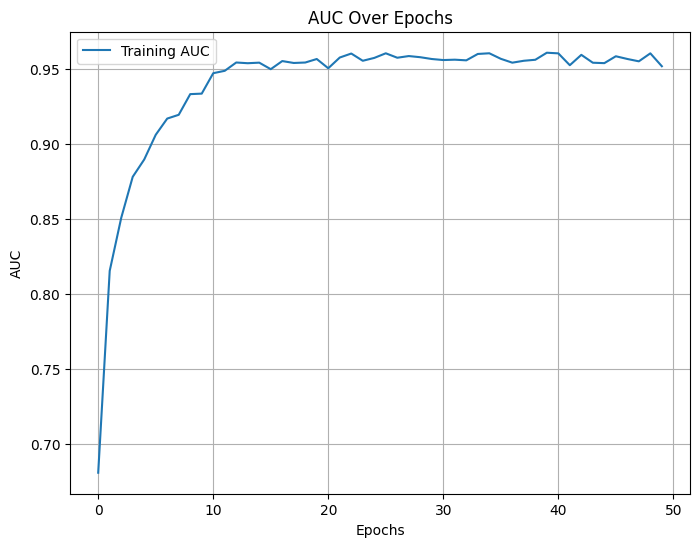

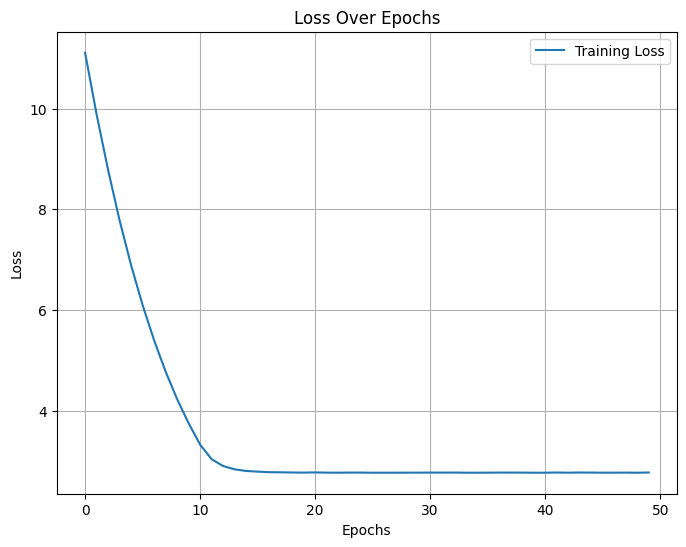

In [7]:
import os
import numpy as np
import tensorflow as tf
from keras_vggface.vggface import VGGFace
from keras_vggface.utils import preprocess_input
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import normalize
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt

# Enable GPU memory growth
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print("Error enabling GPU memory growth:", e)

# Paths
base_dir = os.path.join('dataset', 'lfw-deepfunneled', 'lfw-deepfunneled')
pairs_train_path = 'pairsDevTrain.txt'
pairs_test_path = 'pairsDevTest.txt'

# Normalize file and directory names for compatibility
def normalize_name(name):
    return name.replace(' ', '_')

# Function to load pairs from the LFW pairs file
def load_pairs(pairs_path, base_dir):
    pairs = []
    with open(pairs_path, 'r') as f:
        for line in f.readlines()[1:]:
            parts = line.strip().split()
            if len(parts) == 3:  # Positive pair
                person, img1, img2 = parts
                person = normalize_name(person)
                img1_path = os.path.join(base_dir, person, f"{person}_{int(img1):04d}.jpg")
                img2_path = os.path.join(base_dir, person, f"{person}_{int(img2):04d}.jpg")
                if os.path.exists(img1_path) and os.path.exists(img2_path):
                    pairs.append((img1_path, img2_path, 1))
            elif len(parts) == 4:  # Negative pair
                person1, img1, person2, img2 = parts
                person1, person2 = normalize_name(person1), normalize_name(person2)
                img1_path = os.path.join(base_dir, person1, f"{person1}_{int(img1):04d}.jpg")
                img2_path = os.path.join(base_dir, person2, f"{person2}_{int(img2):04d}.jpg")
                if os.path.exists(img1_path) and os.path.exists(img2_path):
                    pairs.append((img1_path, img2_path, 0))
    return pairs

# Load pairs
train_pairs = load_pairs(pairs_train_path, base_dir)
test_pairs = load_pairs(pairs_test_path, base_dir)

# Combine train and test pairs into a single dataset
all_pairs = train_pairs + test_pairs

# Load SENet backbone from VGGFace2
image_input = Input(shape=(224, 224, 3))
senet_model = VGGFace(model='senet50', input_tensor=image_input, include_top=False, pooling='avg')

# Function to preprocess and augment images
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.6, 1.4],
    horizontal_flip=True,
    shear_range=0.25,
    zoom_range=0.25
)

def preprocess_image(img_path, augment=False):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = preprocess_input(img_array, version=2)  # Use VGGFace2 preprocessing
    if augment:
        img_array = datagen.random_transform(img_array)
    return img_array

# Create focal loss
def focal_loss(alpha=0.25, gamma=2.0):
    def loss(y_true, y_pred):
        bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
        pt = tf.exp(-bce)
        return alpha * (1 - pt) ** gamma * bce
    return loss

# Create classification model for embeddings
classification_input = Input(shape=(2048,))  # Embedding size
x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(classification_input)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
classification_output = Dense(1, activation='sigmoid')(x)

classification_model = Model(inputs=classification_input, outputs=classification_output)
classification_model.compile(optimizer=Adam(learning_rate=1e-4),
                             loss=focal_loss(),
                             metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])

# Function to generate embedding differences and labels
def generate_embedding_data(pairs, model):
    data = []
    labels = []
    for img1_path, img2_path, label in pairs:
        try:
            img1 = preprocess_image(img1_path)
            img2 = preprocess_image(img2_path)
            emb1 = model.predict(np.expand_dims(img1, axis=0), verbose=0)[0]
            emb2 = model.predict(np.expand_dims(img2, axis=0), verbose=0)[0]
            data.append(np.abs(emb1 - emb2))  # Absolute difference between embeddings
            labels.append(label)
        except Exception as e:
            print(f"Error processing pair: {img1_path}, {img2_path}: {e}")
    return np.array(data), np.array(labels)

# Generate data for the combined dataset
X, y = generate_embedding_data(all_pairs, senet_model)

# Compute class weights to handle imbalances
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
class_weights = dict(enumerate(class_weights))

# Learning rate scheduler
def lr_schedule(epoch, lr):
    if epoch > 10:
        return lr * 0.5
    return lr

# Train the classification model
callbacks = [
    ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, min_lr=1e-7, verbose=1),
    EarlyStopping(monitor='auc', patience=10, restore_best_weights=True, verbose=1),
    LearningRateScheduler(lr_schedule, verbose=1)
]

history = classification_model.fit(
    X, y,
    epochs=50,
    batch_size=64,
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=1
)

# Evaluate the classification model
accuracy = classification_model.evaluate(X, y, verbose=0)[1]
y_pred = (classification_model.predict(X) > 0.5).astype(int)
y_probs = classification_model.predict(X)
auc = roc_auc_score(y, y_probs)

print("Classification Report:")
print(classification_report(y, y_pred, target_names=["Different", "Same"]))
print(f"AUC: {auc * 100:.2f}%")
print(f"Accuracy: {accuracy * 100:.2f}%")

# Plot Accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot AUC
plt.figure(figsize=(8, 6))
plt.plot(history.history['auc'], label='Training AUC')
plt.title('AUC Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()
plt.grid(True)
plt.show()

# Plot Loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()